In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.integrate import cumulative_trapezoid
from ad99 import AlexanderDunkerton1999
from constants import GRAV,R_DRY,C_P

from glob import iglob 
import os

## Load in MiMA data
ds = xr.open_dataset('data/atmos_daily_omega.nc')
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')

ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')

interp_mask = ds_mask_trop.interp(lat=ds.lat,lon=ds.lon,method='nearest').astype(bool)
total_mask = sum(interp_mask[d] for d in interp_mask.data_vars)
total_mask = sum(interp_mask[d] for d in interp_mask.data_vars)

ocean_expac = ds.where(total_mask).stack(points = ['lat','lon'])
ocean_expac = ocean_expac.dropna('points',how='all')
ocean_expac = ocean_expac[['ucomp','temp','vcomp','height','gwfu_cgwd','gwfv_cgwd','omega']]
ocean_expac = ocean_expac.transpose('time','points','pfull')

us = ocean_expac.ucomp.values[...,::-1].reshape(-1,40)
zs = ocean_expac.height.values[...,::-1].reshape(-1,40)
temps= ocean_expac.temp.values[...,::-1].reshape(-1,40)
omega = ocean_expac.omega.values[...,::-1].reshape(-1,40)
gwfu = ocean_expac.gwfu_cgwd.values[...,::-1].reshape(-1,40)
gwfv = ocean_expac.gwfv_cgwd.values[...,::-1].reshape(-1,40)
pfull = ocean_expac.pfull.values[...,::-1].reshape(-1,40)


dTdz = np.gradient(temps,axis=-1)/np.gradient(zs,axis=-1)
Ns2 = GRAV/temps*(dTdz + GRAV/C_P) 
bflim = 1e-4 
Ns2 = xr.where(Ns2 < bflim**2,bflim**2,Ns2)
Ns = np.sqrt(Ns2)
rho = (100*pfull.reshape((1,-1)))/(R_DRY*temps)

In [2]:
ocean_expac

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 360, pfull: 40, points: 2504)
Coordinates:
  * time       (time) object 3kB 0021-01-01 01:00:00 ... 0021-12-30 01:00:00
  * pfull      (pfull) float32 160B 0.1782 0.5562 0.7238 ... 821.4 902.2 970.5
  * points     (points) object 20kB MultiIndex
  * lat        (points) float32 10kB -62.79 -62.79 -62.79 ... 48.84 48.84 48.84
  * lon        (points) float32 10kB 0.0 2.812 5.625 8.438 ... 343.1 345.9 348.8
Data variables:
    ucomp      (time, points, pfull) float32 144MB -53.77 -7.291 ... 23.07 21.66
    temp       (time, points, pfull) float32 144MB 219.6 281.1 ... 280.2 285.8
    vcomp      (time, points, pfull) float32 144MB 14.42 9.985 ... 14.27 14.32
    height     (time, points, pfull) float32 144MB 6.107e+04 5.349e+04 ... 293.8
    gwfu_cgwd  (time, points, pfull) float32 144MB -1.206e-05 1.588e-05 ... 0.0
    gwfv_cgwd  (time, points, pfull) float32 144MB -1.653e-05 -8.299e-06 ... 0.0
    omega      (time, points, pfull) float32 144MB -0.0001554 ... -0.01206
Attributes:
    filename:  atmos_hourly_omega.nc
    title:     MiMA
    history:   Thu Apr  3 00:55:52 2025: ncatted -a calendar,time,o,c,360_day...
    NCO:       netCDF Operators version 5.2.4 (Homepage = http://nco.sf.net, ...

In [3]:
ad99 = AlexanderDunkerton1999(source_level_height=18000,dc=5,cmax=100,base_wavelength=10e3)

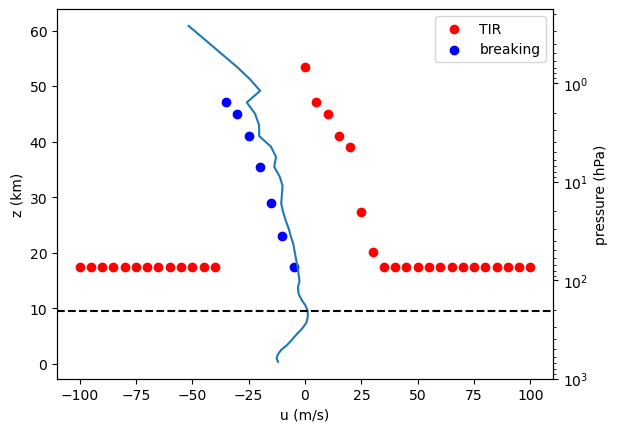

In [4]:
ID = 140
## AD99 VARIABLES

idx_z_source = np.argmin(np.abs(zs[ID] - 9000))
z_source = zs[ID][idx_z_source]
cs = ad99.c0
tir_levels,breaking_levels = ad99.get_breaking_levels(us[ID],Ns[ID],zs[ID],rho[ID])


plt.plot(us[ID],zs[ID]/1000)
plt.xlabel('u (m/s)')
plt.ylabel('z (km)')
plt.axhline(z_source/1000,linestyle='--',color='k')
first_t = False
first_b = False
for c,t,b in zip(cs,tir_levels,breaking_levels):
    if t > 0:
        if t == idx_z_source:
            plt.scatter(c,zs[ID][t]/1000,marker='x',color='r')
        else:
            plt.scatter(c,zs[ID][t]/1000,marker='o',color='r',label='TIR' if not first_t else None)
            first_t = True
    elif b > 0:
        if b == idx_z_source:
            plt.scatter(c,zs[ID][b]/1000,marker='x',color='b')
        else:
            plt.scatter(c,zs[ID][b]/1000,marker='o',color='b',label='breaking' if not first_b else None)
            first_b = True
plt.legend()
ax2 = plt.gca().twinx()
ax2.set_yscale('log')
ax2.set_ylabel('pressure (hPa)')
ax2.set_ylim(max(pfull[0]),min(pfull[0]))
ax2.set_yticks([1000,100,10,1])
print()

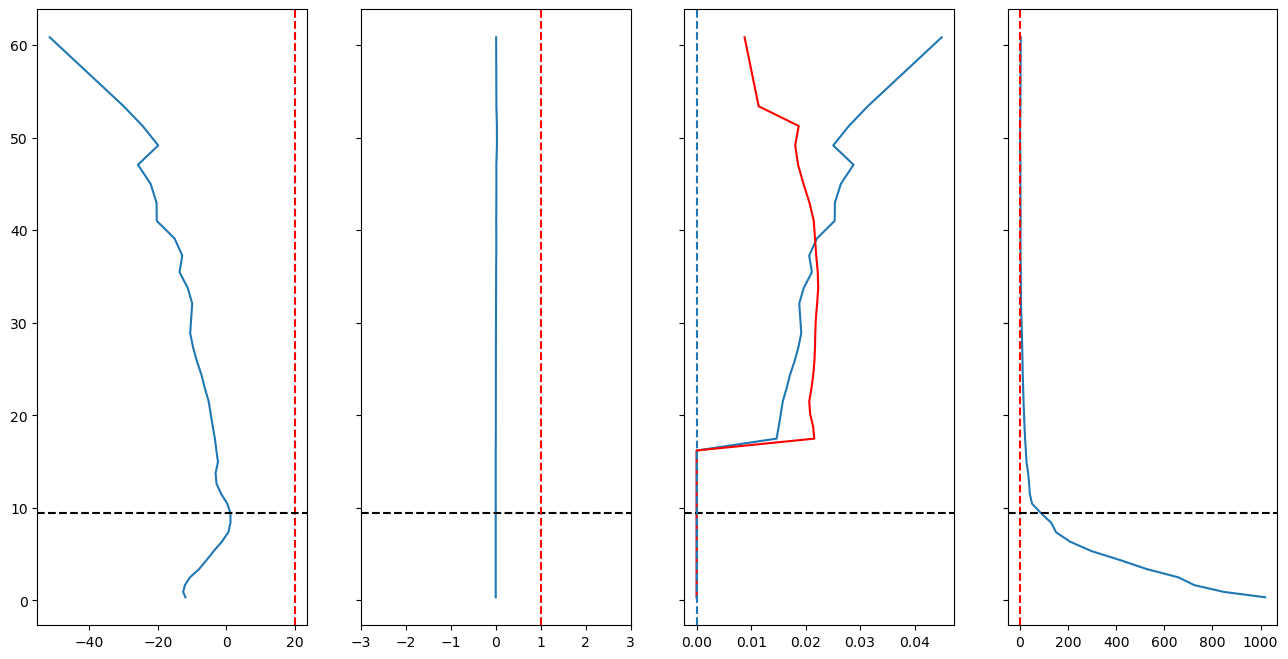

In [5]:
c=20
B_m = ad99.source_spectrum(c,us[ID][idx_z_source])
F_m = B_m*rho[ID][idx_z_source]
fp0 = (ad99.kwv*rho[ID]/(2*Ns[ID]))*(c - us[ID])**3
f_max = 2*np.pi/(24*3600)
Q0, intrinsic_freqs, ref_freq = ad99.inspect_monochromatic(us[ID],Ns[ID],zs[ID],rho[ID],c)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,8),sharey=True)
ax1.plot(us[ID],zs[ID]/1000)
ax1.axvline(c,linestyle='--',color='red')
ax1.axhline(z_source/1000,linestyle='--',color='k')
## stability plot 
ax2.plot(Q0,zs[ID]/1000)
ax2.axhline(z_source/1000,linestyle='--',color='k')
ax2.set_xlim(-3,3)
ax2.axvline(1,linestyle='--',color='red')

ax3.plot(intrinsic_freqs,zs[ID]/1000,label='intrinsic freq')
ax3.plot(ref_freq,zs[ID]/1000,color='red',label='TIR freq')
ax3.axhline(z_source/1000,linestyle='--',color='k')
ax3.axvline(f_max,linestyle='--')

ax4.plot(fp0,zs[ID]/1000)
ax4.axvline(F_m,linestyle='--',color='red')
ax4.axhline(z_source/1000,linestyle='--',color='k')

In [6]:
jan_mean_midlat = ds.sel(time=ds.time.dt.month==1).sel(lat=40,method='nearest').mean(dim=['time','lon'])
u = jan_mean_midlat.ucomp.values[::-1]
z = jan_mean_midlat.height.values[::-1]
pfull = jan_mean_midlat.pfull.values[::-1]
omega = jan_mean_midlat.omega.values[::-1]
temp = jan_mean_midlat.temp.values[::-1]

dTdz_jan = np.gradient(temp,axis=-1)/np.gradient(z,axis=-1)
Ns2_jan = GRAV/temp*(dTdz_jan + GRAV/C_P) 
bflim = 1e-4 
Ns2_jan = xr.where(Ns2_jan < bflim**2,bflim**2,Ns2_jan)
Ns_jan = np.sqrt(Ns2_jan)
rho_jan = (100*jan_mean_midlat.pfull.values)/(R_DRY*temp)

In [7]:
### Alternate params

u = np.linspace(10,-50,len(z))

N = np.ones_like(z)*1e-2

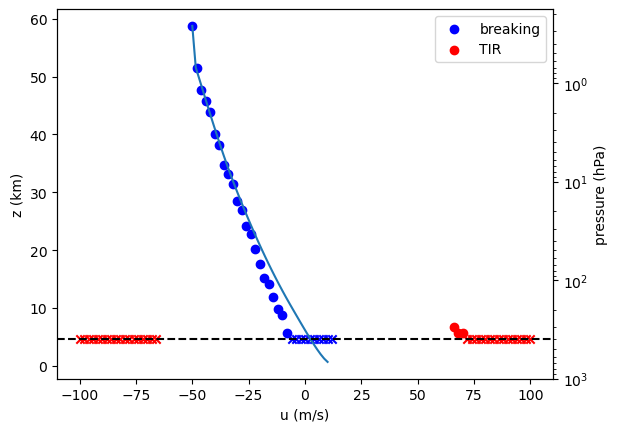

In [13]:
ad99 = AlexanderDunkerton1999(source_level_height=5000,dc=2,cmax=100,base_wavelength=300e3,no_alpha=False,cw=25,Bm=1.2,Fs0=4e-3)
idx_z_source = np.argmin(np.abs(z - ad99.source_level_height))
z_source = z[idx_z_source]
cs = ad99.c0
tir_levels,breaking_levels = ad99.get_breaking_levels(u,Ns_jan,z,rho_jan)


plt.plot(u,z/1000)
plt.xlabel('u (m/s)')
plt.ylabel('z (km)')
plt.axhline(z_source/1000,linestyle='--',color='k')
first_t = False
first_b = False
for c,t,b in zip(cs,tir_levels,breaking_levels):
    if t > 0:
        if t == idx_z_source:
            plt.scatter(c,z[t]/1000,marker='x',color='r')
        else:
            plt.scatter(c,z[t]/1000,marker='o',color='r',label='TIR' if not first_t else None)
            first_t = True
    elif b > 0:
        if b == idx_z_source:
            plt.scatter(c,z[b]/1000,marker='x',color='b')
        else:
            plt.scatter(c,z[b]/1000,marker='o',color='b',label='breaking' if not first_b else None)
            first_b = True
plt.legend()
ax2 = plt.gca().twinx()
ax2.set_yscale('log')
ax2.set_ylabel('pressure (hPa)')
ax2.set_ylim(max(pfull),min(pfull))
ax2.set_yticks([1000,100,10,1])
print()

(-10.0, 10.0)

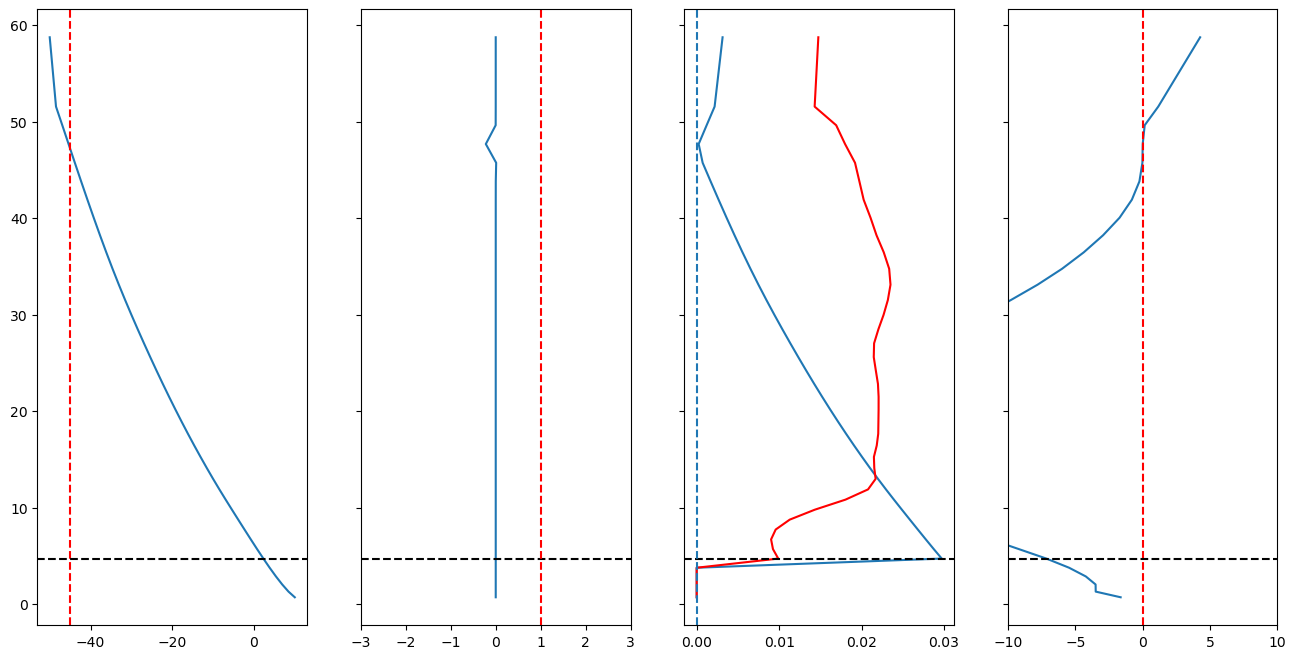

In [11]:
c=-45
B_m = ad99.source_spectrum(c,u[idx_z_source])
F_m = B_m*rho_jan[idx_z_source]
fp0 = (ad99.kwv*rho_jan/(2*Ns_jan))*(c - u)**3
f_max = 2*np.pi/(24*3600)
Q0, intrinsic_freqs, ref_freq = ad99.inspect_monochromatic(u,Ns_jan,z,rho_jan,c)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,8),sharey=True)
ax1.plot(u,z/1000)
ax1.axvline(c,linestyle='--',color='red')
ax1.axhline(z_source/1000,linestyle='--',color='k')
## stability plot 
ax2.plot(Q0,z/1000)
ax2.axhline(z_source/1000,linestyle='--',color='k')
ax2.set_xlim(-3,3)
ax2.axvline(1,linestyle='--',color='red')

ax3.plot(intrinsic_freqs,z/1000,label='intrinsic freq')
ax3.plot(ref_freq,z/1000,color='red',label='TIR freq')
ax3.axhline(z_source/1000,linestyle='--',color='k')
ax3.axvline(f_max,linestyle='--')

ax4.plot(fp0,z/1000)
ax4.axvline(F_m,linestyle='--',color='red')
ax4.axhline(z_source/1000,linestyle='--',color='k')
ax4.set_xlim(-10,10)